In [1]:
import pandas as pd
import numpy as np
import os 
import glob, os
from scipy import stats
#from geopy.distance import great_circle
#from geopy.distance import geodesic
#import geopandas
#import contextily as ctx
import matplotlib.pyplot as plt
%matplotlib inline
import pickle

In [17]:


#Get 2019,2020 MTA into dataframes

df_list_2020=[]
for filename in glob.iglob('turnstile_mta/2020/**.txt', recursive=True):
    if os.path.isfile(filename): # filter dirs
        df_list_2020.append(pd.read_csv(filename))
        
        
df_list_2019=[]
for filename in glob.iglob('turnstile_mta/2019/**.txt', recursive=True):
    if os.path.isfile(filename): # filter dirs
        df_list_2019.append(pd.read_csv(filename))
        




In [18]:
mta_2020_df = pd.concat(df_list_2020)
mta_2019_df = pd.concat(df_list_2019)



In [22]:
def clean_mta(turnstiles_df):
    """
    Converts input MTA data from total cumulative counts per 
    turnstile to new entries and exits at the time of each record. 
    Also adds datetime.
    
    
    """
    
    #convert column names to lower case and eliminate trailing spaces
    turnstiles_df.columns = map(lambda x: x.lower().replace(' ',''),
        turnstiles_df.columns)
    
    #sort by specific turnstiles and add converted counts
    df = turnstiles_df.sort_values(by = ['c/a','unit','scp','station',
        'linename','date','time'])
    df['coming'] = df['entries'].diff()
    df['going'] = df['exits'].diff()
    
    #add id to identify turnstiles with one column
    df['id'] = df['c/a']+df['unit']+df['scp']+df['station']+df['linename']
    
    #eliminate edges between different turnstiles
    mask = (df.id == df.id.shift(1)) & (df.id == df.id.shift(-1))
    df[['coming', 'going']] = df[['coming','going']].where(mask,
        other=np.nan)
    
    def rollover_correcter(value):
        #normal/possible values
        if 0 < value < 5000:
            return value
        #correct for turnstiles that are running backwards
        elif -5000 < value < 0:
            return -value
        #correct for turnstiles that have rolled over
        elif -2147483647 <= value < -2147478647:
            return value+2147483647
        #correct for backwards turnstiles that have rolled over
        elif 2147478647 < value <= 2147483647:
            return 2147483647-value
        #throw out unknown issues
        else:
            return np.nan
    
    df['entries'] = df.coming.apply(rollover_correcter)
    df['exits'] = df.going.apply(rollover_correcter)
    df.dropna(inplace=True)
    df['datetime'] = pd.to_datetime(df['date']+' '+df['time'])
    df.drop('coming', axis=1, inplace=True)
    df.drop('going', axis=1, inplace=True)
    df.drop('id', axis=1, inplace=True)
    return df

In [23]:
cleaned_mta_2019 = clean_mta(mta_2019_df)
cleaned_mta_2020 = clean_mta(mta_2020_df)

In [25]:
import pickle

with open('cleaned_mta_2019', 'wb') as to_write:
    pickle.dump(cleaned_mta_2019, to_write)
    
with open('cleaned_mta_2020', 'wb') as to_write:
    pickle.dump(cleaned_mta_2020, to_write)

In [2]:
with open('cleaned_mta_2019','rb') as read_file:
    cleaned_mta_2019 = pickle.load(read_file)
    
with open('cleaned_mta_2020','rb') as read_file:
    cleaned_mta_2020 = pickle.load(read_file)

In [3]:
def mta_by_time(df,interval,year):
    df['date'] = df['datetime'].dt.date
    df['week'] = df['datetime'].dt.week
    df['month'] = df['datetime'].dt.month_name()
    df['year'] = df['datetime'].dt.year
    df['weekday'] = df['datetime'].dt.day_name()
    if interval == 'date': group = ['year','date']
    if interval == 'weekday': group = ['weekday']
    if interval == 'month': group = ['year','month']
    if interval == 'year': group = ['year']
    if str(year) == 'any':
        return df.groupby(group)[['entries']].sum().reset_index()
    else:
        new_df = df.groupby(group)[['entries']].sum().reset_index()
        new_df = new_df[new_df['year'] == year].reset_index()
        return new_df.drop(columns=['year','index'])

In [4]:
daily = mta_by_time(cleaned_mta_2020,'date',2020)
daily.columns = ['date','2020_MTA_entries']
daily['2019_MTA_entries'] = mta_by_time(cleaned_mta_2019,'date',2019)['entries']
daily['2020_as_proportion_of_2019']=(daily['2020_MTA_entries']-daily['2019_MTA_entries'])/daily['2019_MTA_entries']
daily.dropna(inplace=True)
daily.set_index('date',inplace=True)

In [8]:
with open('bike_df.pickle','rb') as read_file:
    bike_df = pickle.load(read_file)

In [9]:
bike_df['total']=bike_df.sum(axis=1)

In [10]:
bike_df['total_smoothed']=bike_df['total'].rolling(window=30).mean()

In [11]:
bike_df['year_to_year']=(bike_df['total']-bike_df['total_smoothed'].shift(365))/bike_df['total_smoothed'].shift(365)

In [22]:
bike_df

,Lafayette Ave & St James Pl,Hope St & Union Ave,W 37 St & 5 Ave,Lispenard St & Broadway,Market St & Cherry St,E 6 St & Avenue B,Atlantic Ave & Furman St,E 85 St & York Ave,2 Ave & E 96 St,E 72 St & Park Ave,...,36 Ave & 10 St,Broadway & W 29 St,Perry St & Bleecker St,W 67 St & Broadway,35 St & Broadway,Willoughby Ave & Hall St,Nostrand Ave & Myrtle Ave,total,total_smoothed,year_to_year
date,,,,,,,,,,,,,,,,,,,,,
2018-01-01,4,4,12.0,15.0,8,10.0,10.0,9,15,11.0,...,1.0,16.0,8.0,12,6.0,9,2.0,6266.0,NaN,NaN
2018-01-02,17,8,45.0,32.0,14,47.0,13.0,13,26,19.0,...,2.0,70.0,7.0,40,1.0,17,1.0,19345.0,NaN,NaN
2018-01-03,18,9,78.0,56.0,14,30.0,4.0,23,32,14.0,...,3.0,83.0,18.0,45,5.0,30,3.0,24009.0,NaN,NaN
2018-01-05,3,4,3.0,4.0,2,7.0,2.0,2,5,1.0,...,2.0,2.0,4.0,10,1.0,5,2.0,2980.0,NaN,NaN
2018-01-06,9,4,20.0,10.0,6,19.0,1.0,2,15,2.0,...,4.0,17.0,2.0,5,1.0,7,2.0,5753.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-27,46,55,80.0,75.0,53,91.0,104.0,52,105,24.0,...,45.0,98.0,96.0,48,46.0,33,22.0,46192.0,36527.066667,-0.193907
2020-05-28,40,57,84.0,54.0,49,79.0,85.0,47,72,27.0,...,44.0,80.0,81.0,57,25.0,29,17.0,39063.0,36701.166667,-0.324654
2020-05-29,67,36,63.0,85.0,42,133.0,66.0,58,96,44.0,...,45.0,101.0,98.0,47,34.0,36,18.0,45333.0,37598.466667,-0.213548


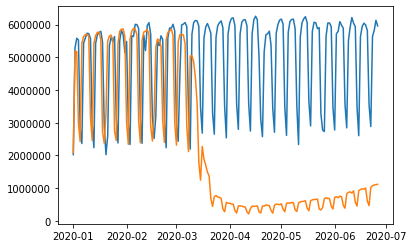

In [5]:
plt.plot(daily['2019_MTA_entries'])
plt.plot(daily['2020_MTA_entries']);

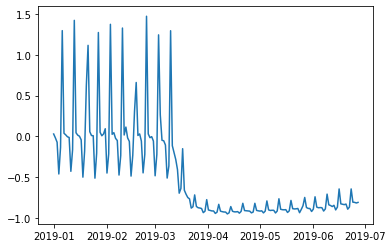

In [51]:
plt.plot(daily['2020_as_proportion_of_2019']);

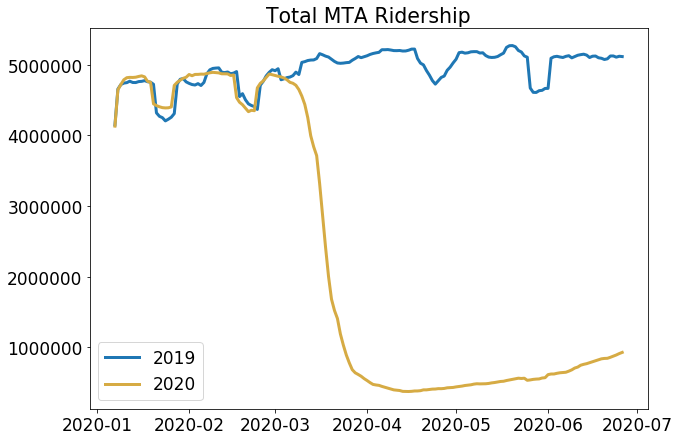

In [14]:

plt.rcParams.update({'font.size': 17})
fig, ax = plt.subplots(figsize=(10,7))

plt.plot(daily['2019_MTA_entries'].rolling(window=7).mean(),
              linewidth=3,
              #xlabel = 'Longitude',
              #ylabel="latitude")
              label = ('2019'))
              #alpha=.5)

plt.plot(daily['2020_MTA_entries'].rolling(window=7).mean(),
              linewidth=3,
              color='#D6AB44',
              #xlabel = 'Longitude',
              #ylabel="latitude")
              label = ('2020'))
              #alpha=.5)
plt.title('Total MTA Ridership')
plt.legend(loc='lower left')
#ax.set_xlabel('Longitude')
#ax.set_ylabel('Proportional Growth from Previous Year')));

Text(0, 0.5, 'Proportional Growth from Previous Year')

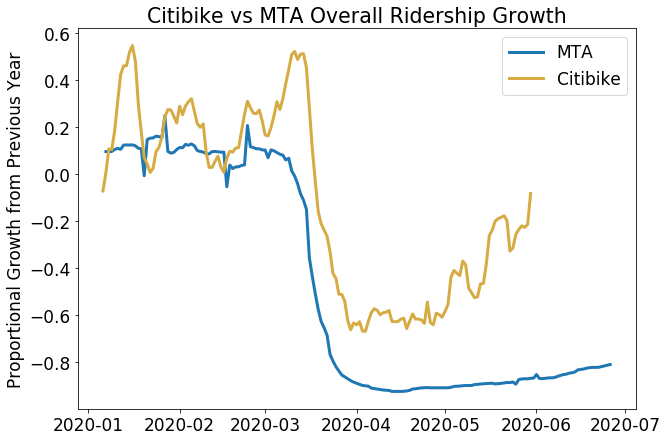

In [12]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
plt.rcParams.update({'font.size': 17})
fig, ax = plt.subplots(figsize=(10,7))
plt.plot(daily['2020_as_proportion_of_2019'].rolling(window=7).mean(),
              linewidth=3,
              #xlabel = 'Longitude',
              #ylabel="latitude")
              label = ('MTA'))
              #alpha=.5)
plt.plot(bike_df.iloc[727:878,765].rolling(window=7).mean(),
              linewidth=3,
              color='#D6AB44',
              #xlabel = 'Longitude',
              #ylabel="latitude")
              label = ('Citibike'))
              #alpha=.5)
plt.title('Citibike vs MTA Overall Ridership Growth')
plt.legend(loc='upper right')
#ax.set_xlabel('Longitude')
ax.set_ylabel('Proportional Growth from Previous Year')

#ax.set_xticks([-74.03,-73.97,-73.91])


In [16]:
bike_2020_df['day']=pd.to_datetime(bike_2020_df['starttime']).dt.dayofyear
daily_bike=bike_2020_df.groupby(['day'])[['gender']].count().reset_index()
daily_bike.columns=['day','bike_2020']
bike_2019_df['day']=pd.to_datetime(bike_2019_df['starttime']).dt.dayofyear
daily_bike_2019=bike_2019_df.groupby(['day'])[['gender']].count().reset_index()
daily_bike['bike_2019']=daily_bike_2019['gender']
daily_bike['bike_%_of_2019']=daily_bike['bike_2020']/daily_bike['bike_2019']
daily_bike


,day,bike_2020,bike_2019,bike_%_of_2019
0,1,370,431.0,0.858469
1,2,892,827.0,1.078597
2,3,772,860.0,0.897674
3,4,566,900.0,0.628889
4,5,501,308.0,1.626623
...,...,...,...,...
147,148,1008,1150.0,0.876522
148,149,692,998.0,0.693387
149,150,770,879.0,0.875995
150,151,1718,1405.0,1.222776


NameError: name 'daily_bike' is not defined

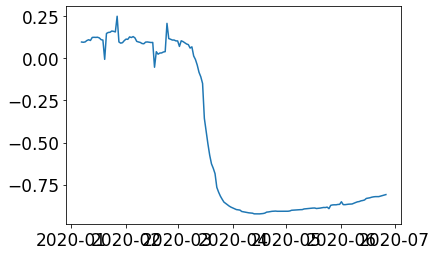

In [88]:
plt.plot(daily['2020_as_proportion_of_2019'].rolling(window=7).mean())
plt.plot(daily_bike['bike_%_of_2019'].rolling(window=15).mean());

In [87]:
plt.plot(daily_bike['bike_2019'].rolling(window=15).mean())
plt.plot(daily_bike['bike_2020'].rolling(window=15).mean());

NameError: name 'daily_bike' is not defined

In [15]:
mta_station_names_2020 = set(cleaned_mta_2020['station'])
mta_station_names_2019 = set(cleaned_mta_2019['station'])
mta_station_names = list(mta_station_names_2020.intersection(mta_station_names_2019))
mta_by_station_2020_df = pd.DataFrame()
#mta_by_station_2019_df = pd.DataFrame()

for name in mta_station_names:
    mta_by_station_2020_df[name] = cleaned_mta_2020[(cleaned_mta_2020['station'] == name) &
        (cleaned_mta_2020['year'] == 2020)].groupby(['date'])[['entries']].sum()['entries']
#mta_by_station_2020_df.dropna(inplace=True)

#for name in mta_station_names:
#    mta_by_station_2019_df[name] = cleaned_mta_2019[(cleaned_mta_2019['station'] == name) &
#        (cleaned_mta_2019['year'] == 2019)].groupby(['day'])[['entries']].sum()['entries']
#mta_by_station_2019_df.dropna(inplace=True)

Text(0, 0.5, 'Rides per Day')

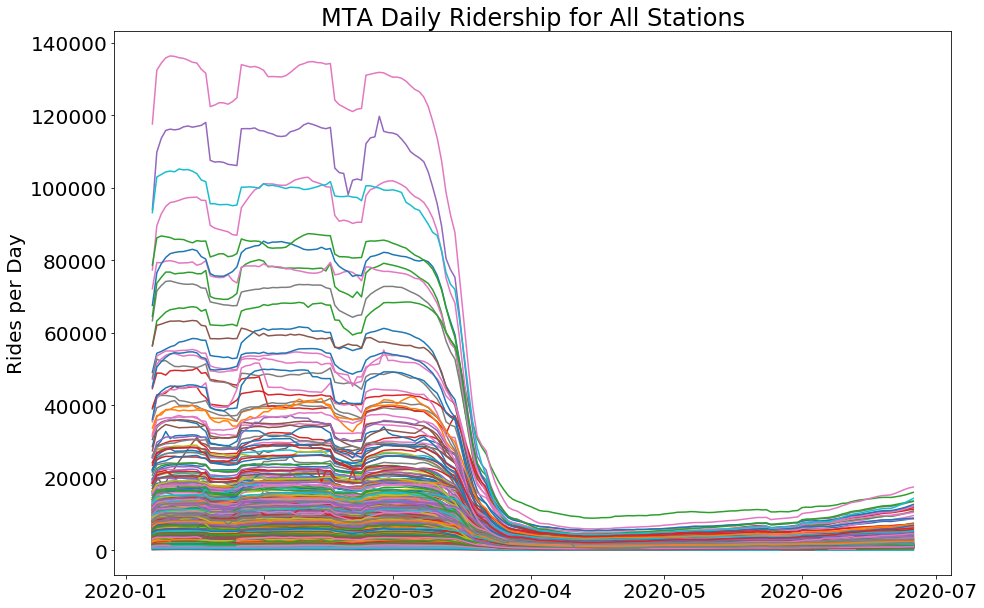

In [20]:
#plt.rcParams.update({'font.size': 17})
#fig, ax = plt.subplots(figsize=(10,7))
plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots(figsize=(15,10))
for name in mta_station_names:
    plt.plot(mta_by_station_2020_df[name].rolling(window=7).mean())
plt.title('MTA Daily Ridership for All Stations')
#plt.legend(loc='upper right')
#ax.set_xlabel('Longitude')
ax.set_ylabel('Rides per Day')

#ax.set_xticks([-74.03,-73.97,-73.91])


#ax.set_xticks([-74.03,-73.97,-73.91])

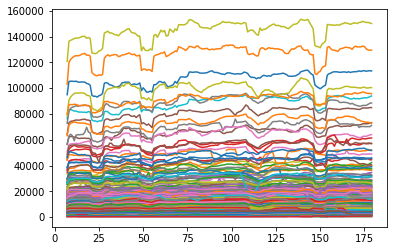

In [44]:
for name in mta_station_names:
    plt.plot(mta_by_station_2019_df[name].rolling(window=7).mean())

In [45]:
mta_by_station_2020_fraction=pd.DataFrame()
for station in mta_station_names:
    mta_by_station_2020_fraction[station]=mta_by_station_2020_df[station]/mta_by_station_2019_df[station]

In [91]:
mta_station_names

['18 AV',
 '46 ST',
 'BROOKLYN BRIDGE',
 '170 ST',
 'CLARK ST',
 '137 ST CITY COL',
 'ALABAMA AV',
 'AVENUE J',
 'JOURNAL SQUARE',
 'FULTON ST',
 'PELHAM BAY PARK',
 '116 ST',
 '5 AV/53 ST',
 'SPRING ST',
 '61 ST WOODSIDE',
 'ALLERTON AV',
 'HOYT ST',
 '5 AV/59 ST',
 '15 ST-PROSPECT',
 'SUTPHIN BLVD',
 '2 AV',
 'COURT SQ',
 'BROAD ST',
 '174 ST',
 'PARKSIDE AV',
 'CHURCH AV',
 'MARCY AV',
 'TREMONT AV',
 'ATL AV-BARCLAY',
 'KOSCIUSZKO ST',
 'NORWOOD 205 ST',
 'MONTROSE AV',
 '52 ST',
 'NEWKIRK PLAZA',
 'ZEREGA AV',
 'RALPH AV',
 '75 AV',
 'PARKCHESTER',
 'INWOOD-207 ST',
 'SENECA AVE',
 '34 ST-HERALD SQ',
 '104 ST',
 'FORDHAM RD',
 'CENTRAL PK N110',
 '72 ST-2 AVE',
 '182-183 STS',
 'KINGSTON-THROOP',
 'VAN SICLEN AV',
 '3 AV',
 'JEFFERSON ST',
 'WTC-CORTLANDT',
 '85 ST-FOREST PK',
 'NEWARK HW BMEBE',
 '96 ST-2 AVE',
 "E 143/ST MARY'S",
 '14 ST-UNION SQ',
 '80 ST',
 '68ST-HUNTER CO',
 '42 ST-PORT AUTH',
 'NEW LOTS',
 'WHITLOCK AV',
 '174-175 STS',
 'PENNSYLVANIA AV',
 'EASTN PKWY-MUSM'

,HUNTS POINT AV,NEWKIRK PLAZA,88 ST,CHAUNCEY ST,75 ST-ELDERTS,39 AV,71 ST,85 ST-FOREST PK,AVENUE J,TIMES SQ-42 ST,...,BAY RIDGE AV,8 ST-NYU,25 ST,86 ST,CARROLL ST,191 ST,GROVE STREET,FRANKLIN ST,FRANKLIN AV,STEINWAY ST
day,,,,,,,,,,,,,,,,,,,,,
1,1.093665,0.963824,1.106918,1.106576,1.070220,NaN,0.907596,1.206774,1.147453,0.962031,...,1.046636,1.018711,1.012100,0.993042,1.064746,1.023340,1.145944,1.070681,1.033954,0.827942
2,1.000931,0.972693,1.013163,0.999326,1.056551,NaN,0.970067,1.081682,0.965197,0.952370,...,1.020476,0.974008,0.972421,0.985161,1.004112,0.979703,1.018128,0.843247,1.012416,0.853797
3,0.964431,0.924310,0.945239,1.007147,1.046837,NaN,0.959255,1.139994,0.866592,0.856889,...,0.980502,0.949704,0.970748,0.941642,0.936321,0.880536,0.950691,0.785318,0.997628,0.870533
4,0.489786,0.493643,0.475522,0.720923,0.567703,NaN,0.559067,0.635585,0.442268,0.551465,...,0.546042,0.749918,0.551412,0.606595,0.515602,0.649738,0.478224,0.385618,0.593527,0.502412
5,0.766831,0.821382,0.868400,0.997833,0.875387,NaN,0.791925,0.987707,0.969283,0.852593,...,0.837160,0.875708,0.812408,0.827325,0.944280,0.874021,0.577780,0.792378,0.855256,0.609114
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,0.346618,0.247231,0.296245,0.267380,0.290465,0.195868,0.253429,0.335498,0.244352,0.117725,...,0.244233,0.102019,0.281612,0.198420,0.135590,0.061779,0.117378,0.253123,0.189272,0.211015
176,0.308518,0.262300,0.311728,0.272947,0.330237,0.186254,0.265794,0.342967,0.262424,0.113399,...,0.242668,0.106453,0.265487,0.188852,0.126803,0.058702,0.119732,0.260260,0.185072,0.191668
177,0.310194,0.234732,0.299106,0.259343,0.310163,0.178699,0.260870,0.319845,0.231325,0.104928,...,0.234841,0.095254,0.282512,0.184916,0.138006,0.059248,0.123813,0.266936,0.178984,0.201167


In [17]:
mta_by_station_2020_df

,59 ST COLUMBUS,NEWARK HW BMEBE,AVENUE X,BEACH 90 ST,NORWOOD AV,CASTLE HILL AV,207 ST,ALABAMA AV,65 ST,INTERVALE AV,...,HIGH ST,ELDER AV,15 ST-PROSPECT,53 ST,NEW UTRECHT AV,DEKALB AV,RECTOR ST,PARK PLACE,238 ST,CANARSIE-ROCKAW
date,,,,,,,,,,,,,,,,,,,,,
2020-01-01,27810.0,567.0,912.0,309.0,1070.0,2151.0,2465.0,730.0,1305.0,1065.0,...,6661.0,2429.0,2096.0,3202.0,2221.0,10099.0,4756.0,1336.0,1361.0,3439.0
2020-01-02,62136.0,5415.0,2654.0,724.0,2844.0,6052.0,5272.0,1902.0,3330.0,2756.0,...,12229.0,5694.0,6012.0,7859.0,5058.0,29544.0,14510.0,4157.0,3919.0,9595.0
2020-01-03,59492.0,4655.0,2611.0,740.0,2975.0,6199.0,5454.0,2061.0,3307.0,2891.0,...,9160.0,5877.0,5997.0,7977.0,4946.0,30098.0,13445.0,3999.0,3964.0,11390.0
2020-01-04,37784.0,707.0,1345.0,420.0,1619.0,3395.0,3950.0,1185.0,2369.0,1622.0,...,6497.0,3853.0,3479.0,4827.0,2582.0,15846.0,5978.0,1796.0,2291.0,5710.0
2020-01-05,31152.0,477.0,1102.0,287.0,1336.0,2582.0,3200.0,978.0,1925.0,1210.0,...,9586.0,3121.0,3004.0,4034.0,2462.0,13099.0,4572.0,1618.0,2028.0,4227.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-22,9392.0,548.0,713.0,406.0,918.0,1796.0,1784.0,709.0,922.0,808.0,...,1164.0,1812.0,758.0,2630.0,1406.0,6662.0,1131.0,669.0,974.0,2142.0
2020-06-23,10023.0,672.0,814.0,429.0,980.0,1848.0,1889.0,799.0,917.0,1014.0,...,1226.0,1963.0,844.0,2836.0,1419.0,7007.0,1170.0,686.0,873.0,2507.0
2020-06-24,10223.0,683.0,840.0,349.0,1106.0,1830.0,1965.0,743.0,925.0,975.0,...,1309.0,1893.0,897.0,2428.0,1433.0,7095.0,1327.0,709.0,1147.0,2513.0


In [26]:
bike_df.iloc[728:879,765]

date
2020-01-01   -0.464390
2020-01-02    0.189437
2020-01-03   -0.087640
2020-01-04   -0.140864
2020-01-05   -0.145333
                ...   
2020-05-27   -0.193907
2020-05-28   -0.324654
2020-05-29   -0.213548
2020-05-30    0.275604
2020-05-31    0.161420
Name: year_to_year, Length: 151, dtype: float64

In [85]:
cleaned_mta_2020

,c/a,unit,scp,station,linename,division,date,time,desc,entries,exits,datetime,day,week,month,year,weekday
25,A002,R051,02-00-00,59 ST,NQR456W,BMT,2020-01-01,07:00:00,REGULAR,7.0,11.0,2020-01-01 07:00:00,1,1,January,2020,Wednesday
26,A002,R051,02-00-00,59 ST,NQR456W,BMT,2020-01-01,11:00:00,REGULAR,31.0,39.0,2020-01-01 11:00:00,1,1,January,2020,Wednesday
27,A002,R051,02-00-00,59 ST,NQR456W,BMT,2020-01-01,15:00:00,REGULAR,118.0,40.0,2020-01-01 15:00:00,1,1,January,2020,Wednesday
28,A002,R051,02-00-00,59 ST,NQR456W,BMT,2020-01-01,19:00:00,REGULAR,182.0,57.0,2020-01-01 19:00:00,1,1,January,2020,Wednesday
29,A002,R051,02-00-00,59 ST,NQR456W,BMT,2020-01-01,23:00:00,REGULAR,124.0,32.0,2020-01-01 23:00:00,1,1,January,2020,Wednesday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206387,TRAM2,R469,00-03-01,RIT-ROOSEVELT,R,RIT,2019-12-31,00:00:00,REGULAR,28.0,1.0,2019-12-31 00:00:00,365,1,December,2019,Tuesday
206388,TRAM2,R469,00-03-01,RIT-ROOSEVELT,R,RIT,2019-12-31,04:00:00,REGULAR,3.0,1.0,2019-12-31 04:00:00,365,1,December,2019,Tuesday
206389,TRAM2,R469,00-03-01,RIT-ROOSEVELT,R,RIT,2019-12-31,08:00:00,REGULAR,2.0,2.0,2019-12-31 08:00:00,365,1,December,2019,Tuesday
206390,TRAM2,R469,00-03-01,RIT-ROOSEVELT,R,RIT,2019-12-31,12:00:00,REGULAR,59.0,3.0,2019-12-31 12:00:00,365,1,December,2019,Tuesday
